## Objectif du Projet

L'objectif principal de ce projet est de construire, d'évaluer et de comparer deux pipelines de prévision distincts pour un ETF sectoriel. En utilisant les mêmes données d'entrée (prix de l'ETF et indicateurs macroéconomiques comme le PIB, l'inflation et les ventes au détail), nous cherchons à :
-   **Modéliser la trajectoire future du prix de l'ETF** en utilisant les deux approches.
-   **Quantifier l'incertitude et la volatilité** associées à ces prévisions.
-   **Comparer la performance et l'interprétabilité** des modèles issus du Machine Learning et de l'Économétrie.

Le projet vise à fournir un cadre d'analyse complet, de la collecte des données à la génération de prévisions et de simulations, illustrant comment différentes philosophies de modélisation peuvent être appliquées au même problème financier.

---

## Structure du Projet et Méthodologie

Ce notebook adopte une approche économétrique classique, en modélisant séparément la tendance (rendements) et la volatilité.

**Étapes clés :**
1.  **Collecte et Préparation des Données :** Mêmes sources que le notebook ML, avec un accent sur le calcul des rendements et de la volatilité historique.
2.  **Modélisation de la Tendance (SARIMAX) :**
    -   Recherche des meilleurs paramètres `(p,d,q)(P,D,Q)` pour un modèle **SARIMAX** via une validation croisée sur séries temporelles, en utilisant un indicateur macroéconomique comme variable exogène.
    -   Entraînement du meilleur modèle et analyse des prévisions sur l'ensemble de test.
    -   Génération des prévisions de rendements futurs.
3.  **Modélisation de la Volatilité (GARCH-X) :**
    -   Recherche des meilleurs ordres `(p,q)` pour un modèle **GARCH-X**, en utilisant également une variable exogène.
    -   Entraînement du meilleur modèle et génération des prévisions de volatilité future.
4.  **Synthèse et Simulation (Monte Carlo) :**
    -   Les prévisions de rendements (SARIMAX) sont converties en une trajectoire de prix.
    -   Les prévisions de volatilité (GARCH-X) sont utilisées comme mesure de l'incertitude.
    -   Une **simulation de Monte Carlo** est lancée pour générer de multiples trajectoires de prix possibles autour de la prévision centrale, fournissant une distribution des résultats potentiels.
5.  **Analyse des Résultats :**
    -   Visualisation des prévisions de rendements, de prix, et de volatilité.
    -   Affichage du cône des simulations de Monte Carlo.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from joblib import Memory
from arch import arch_model
import traceback
from tqdm import tqdm
import matplotlib.ticker as mticker
from scipy.stats import norm
import yfinance as yf
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
from sklearn.model_selection import TimeSeriesSplit
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error

In [2]:
etf_symbols = ['XLI']

start_date = '1900-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

def get_etf_data(etf_symbol):
    etf = yf.download(etf_symbol, start=start_date, end=end_date)
    return etf

etf_data = pd.DataFrame()

for symbol in etf_symbols:
    etf = get_etf_data(symbol)
    etf_data[symbol] = etf['Close']

etf_data = etf_data.astype(float)
etf_data.reset_index(inplace=True)

etf_data['Date'] = pd.to_datetime(etf_data['Date'])
etf_data['Quarter'] = etf_data['Date'].dt.to_period('M')
etf_data = etf_data.groupby('Quarter').mean().reset_index()
premiere_dates_trimestre = etf_data.groupby('Quarter')['Date'].first().reset_index()
etf_data['Date'] = premiere_dates_trimestre['Date']
etf_data = etf_data.reindex(columns=['Date', 'XLI'])
etf_data['Date'] = etf_data['Date'].dt.strftime('%Y-%m')

etf_data

[*********************100%***********************]  1 of 1 completed


,Date,XLI
0,1998-12,15.013717
1,1999-01,15.197803
2,1999-02,15.269105
3,1999-03,15.632312
4,1999-04,17.146042
...,...,...
318,2025-06,143.187578
319,2025-07,150.464274
320,2025-08,150.863383
321,2025-09,151.514410


In [3]:
api_key = "8e877013bcb3862ac90cd864024bdb75"

def download_fred_data(series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&observation_start={start_date}&observation_end={end_date}&file_type=json"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.rename(columns={'value': series_id}, inplace=True)
    return df

retail_sales_data = download_fred_data("RSXFS", "1900-01-01", "2024-12-31")
retail_sales_data['RSXFS'] = pd.to_numeric(retail_sales_data['RSXFS'], errors='coerce')
retail_sales_data .index = pd.to_datetime(retail_sales_data .index)
retail_sales_data  = retail_sales_data .asfreq('M', method='ffill')
retail_sales_data .reset_index(inplace=True)
retail_sales_data ['Date'] = retail_sales_data ['date'].dt.strftime('%Y-%m')
retail_sales_data .drop(columns=['date'], inplace=True)
retail_sales_data  = retail_sales_data [['RSXFS', 'Date']]

datasets = [
    ("etf_data", "MS"),
    ("retail_sales_data", "MS"),
]

combined_data = globals()[datasets[0][0]]

for data_name, _ in datasets[1:]:
    data = globals()[data_name]
    pmi_data = pd.merge(combined_data, data, on='Date')

pmi_data

,Date,XLI,RSXFS
0,1998-12,15.013717,217396.0
1,1999-01,15.197803,217930.0
2,1999-02,15.269105,220769.0
3,1999-03,15.632312,222199.0
4,1999-04,17.146042,223837.0
...,...,...,...
307,2024-07,121.941629,605814.0
308,2024-08,123.989321,603719.0
309,2024-09,128.911803,608701.0
310,2024-10,134.532458,612570.0


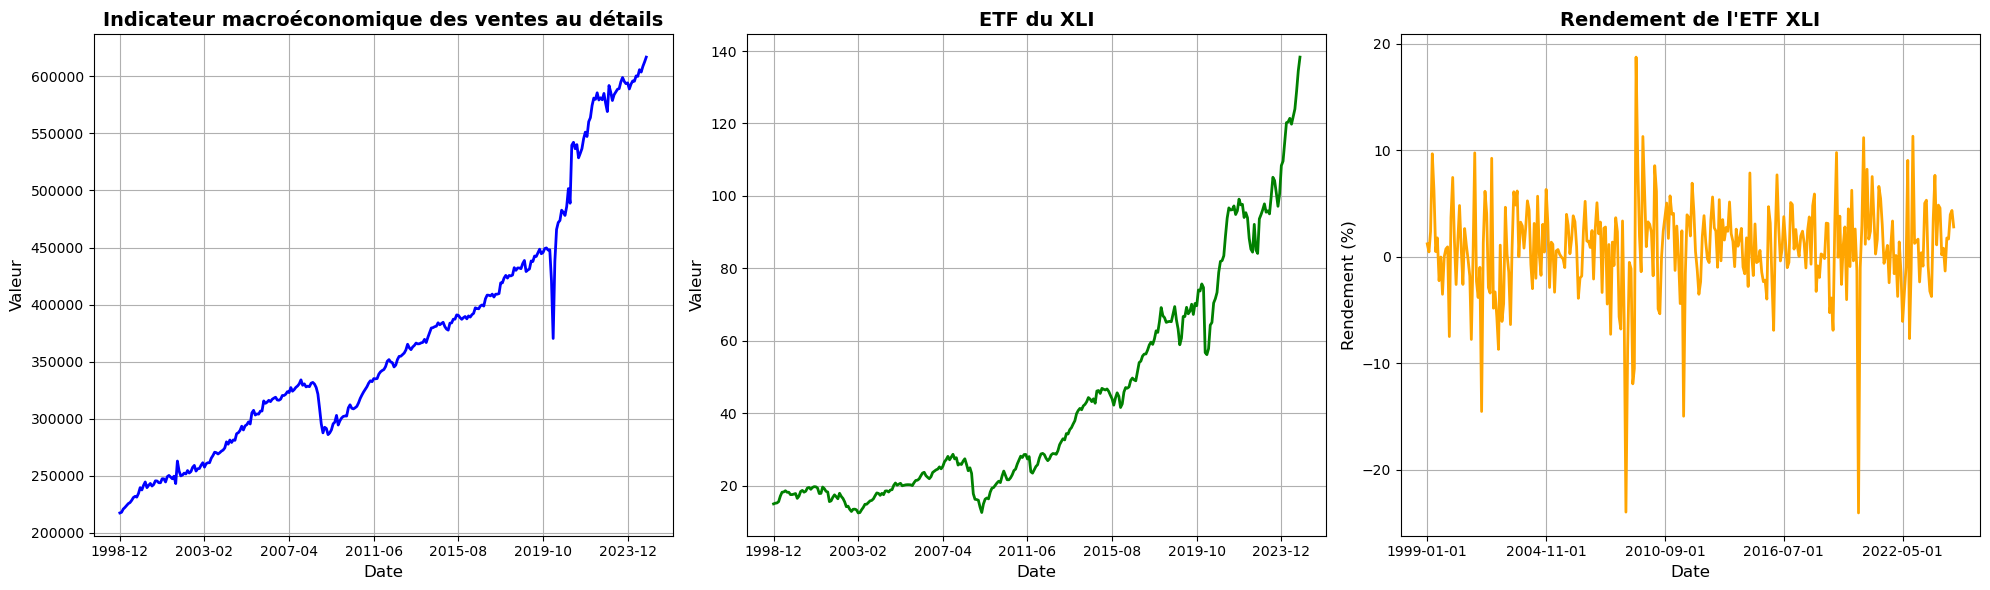

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

axes[0].plot(pmi_data['Date'], pmi_data['RSXFS'], color='blue', linewidth=2)
axes[0].set_title('Indicateur macroéconomique des ventes au détails', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Valeur', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True)
axes[0].set_xticks(pmi_data['Date'][::50])

axes[1].plot(pmi_data['Date'], pmi_data['XLI'], color='green', linewidth=2)
axes[1].set_title('ETF du XLI', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Valeur', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(True)
axes[1].set_xticks(pmi_data['Date'][::50])

pmi_data['Returns'] = pmi_data['XLI'].pct_change() * 100
pmi_data.dropna(inplace=True)
pmi_data['Date'] = pd.to_datetime(pmi_data['Date'])
axes[2].plot(pmi_data['Date'], pmi_data['Returns'], color='orange', linewidth=2)
axes[2].set_title('Rendement de l\'ETF XLI', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Rendement (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=0)
axes[2].grid(True)
axes[2].set_xticks(pmi_data['Date'][::70])

plt.tight_layout()
plt.show()

In [5]:
merged_data = pmi_data[['Date', 'RSXFS', 'Returns']]   
merged_data.reset_index(drop=True, inplace=True)

X = merged_data['Returns'].values

memory = Memory(location='cache_folder', verbose=0)

p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

@memory.cache
def fit_sarimax(train, exog, param, param_seasonal):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = SARIMAX(train, exog=exog, order=param, seasonal_order=param_seasonal,
                            enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(max_iter=1000)
        return results.aic
    except Exception as e:
        return None

list_param = []
list_param_seasonal = []
list_results_aic = []

best_aic = float('inf')

time_series_splits = TimeSeriesSplit(n_splits=5)

try:
    for index, (train_index, test_index) in enumerate(time_series_splits.split(X)):
        train, test = X[train_index], X[test_index]
        for param, param_seasonal in zip(pdq, seasonal_pdq):
            aic = fit_sarimax(train, exog=merged_data.loc[train_index, ['RSXFS']],
                              param=param, param_seasonal=param_seasonal)
            if aic is not None:
                if aic < best_aic:
                    best_aic = aic
                list_param.append(param)
                list_param_seasonal.append(param_seasonal)
                list_results_aic.append(aic)

except KeyboardInterrupt:
    print("\nInterruption de l'exécution.")

min_aic_index = np.argmin(list_results_aic)

best_param = list_param[min_aic_index]
best_param_seasonal = list_param_seasonal[min_aic_index]
best_aic = list_results_aic[min_aic_index]

print(f"Meilleurs paramètres (p,d,q) : {best_param}")
print(f"Meilleurs paramètres saisonniers (P,D,Q,s) : {best_param_seasonal}")
print(f"Meilleur AIC obtenu : {best_aic}")

Meilleurs paramètres (p,d,q) : (1, 1, 0)
Meilleurs paramètres saisonniers (P,D,Q,s) : (1, 1, 0, 12)
Meilleur AIC obtenu : 207.1254274719995


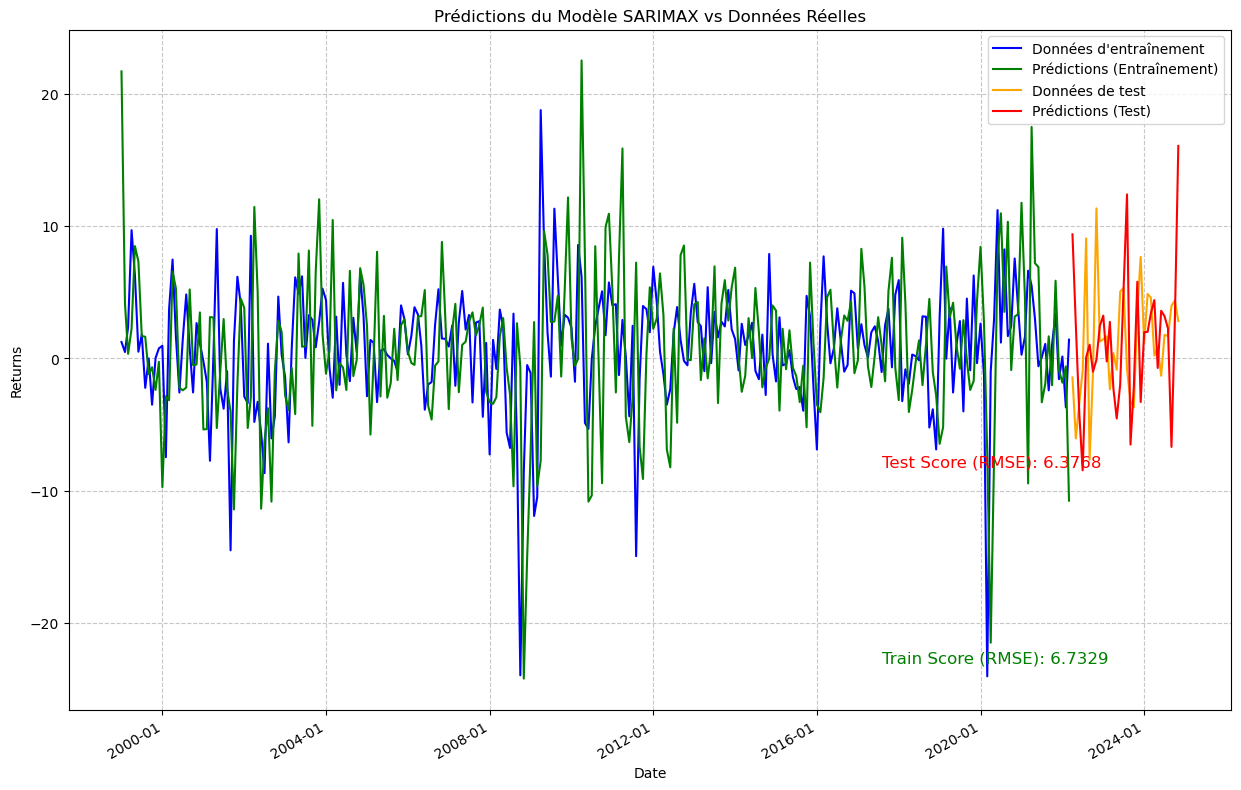

In [6]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

percentages = np.arange(0.1, 1, 0.1)

best_mean_error = float('inf')
best_train_percentage_for_best_error = None

for train_percentage in percentages:
    train_size = int(len(X) * train_percentage)
    test_size = len(X) - train_size

    train_data = X[:train_size]
    test_data = X[train_size:]

    exog_train = merged_data[['RSXFS']].values[:train_size]
    exog_test = merged_data[['RSXFS']].values[train_size:]

    model = SARIMAX(train_data, exog=exog_train, order=best_param, seasonal_order=best_param_seasonal,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(max_iter=1000)

    test_forecast = results.predict(start=train_size, end=train_size + test_size-1, exog=exog_test)

    prediction_error = np.abs(test_data - test_forecast)
    mean_error = np.mean(prediction_error)

    if mean_error < best_mean_error:
        best_mean_error = mean_error
        best_train_percentage_for_best_error = train_percentage

train_predictions = []
test_predictions = []

train_percentage = best_train_percentage_for_best_error

train_size = int(len(X) * train_percentage)
test_size = len(X) - train_size

train_data = X[:train_size]
test_data = X[train_size:]

exog_train = merged_data[['RSXFS']].values[:train_size]
exog_test = merged_data[['RSXFS']].values[train_size:]

best_model = SARIMAX(train_data, exog=exog_train, order=best_param, seasonal_order=best_param_seasonal,
                     enforce_stationarity=False, enforce_invertibility=False)
best_results = best_model.fit(max_iter=1000)

train_forecast = best_results.predict(start=0, end=train_size-1, exog=exog_train)
train_predictions.extend(train_forecast)

first_forecast = best_results.forecast(steps=1, exog=exog_test[0].reshape(1, -1))
test_predictions.extend(first_forecast)

for i in range(1, len(test_data)):
    model = SARIMAX(np.append(train_data, test_data[:i]), exog=np.append(exog_train, exog_test[:i], axis=0)
                    ,order=best_param, seasonal_order=best_param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    results = model.fit(max_iter=200)

    next_forecast = results.forecast(steps=1, exog=exog_test[i].reshape(1, -1))

    test_predictions.append(next_forecast[0])

train_predictions = np.array(train_predictions)
test_predictions = np.array(test_predictions)

train_score = np.sqrt(mean_squared_error(train_data, train_predictions))
test_score = np.sqrt(mean_squared_error(test_data, test_predictions))


merged_data['Date'] = pd.to_datetime(merged_data['Date'])

train_dates = merged_data['Date'].iloc[:train_size]
test_dates = merged_data['Date'].iloc[train_size:train_size + test_size]

plt.figure(figsize=(15, 10))

plt.plot(train_dates, train_data, label='Données d\'entraînement', color='blue')
plt.plot(train_dates, train_predictions, label='Prédictions (Entraînement)', color='green')
plt.plot(test_dates, test_data, label='Données de test', color='orange')
plt.plot(test_dates, test_predictions, label='Prédictions (Test)', color='red')

plt.text(train_dates.iloc[int(train_size*0.8)], min(train_data) + 1, f'Train Score (RMSE): {train_score:.4f}', color='green', fontsize=12)
plt.text(train_dates.iloc[int(train_size*0.8)], min(test_data) - 0.5, f'Test Score (RMSE): {test_score:.4f}', color='red', fontsize=12)

plt.xlabel('Date') 
plt.ylabel('Returns')
plt.title('Prédictions du Modèle SARIMAX vs Données Réelles')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate() 

plt.show()

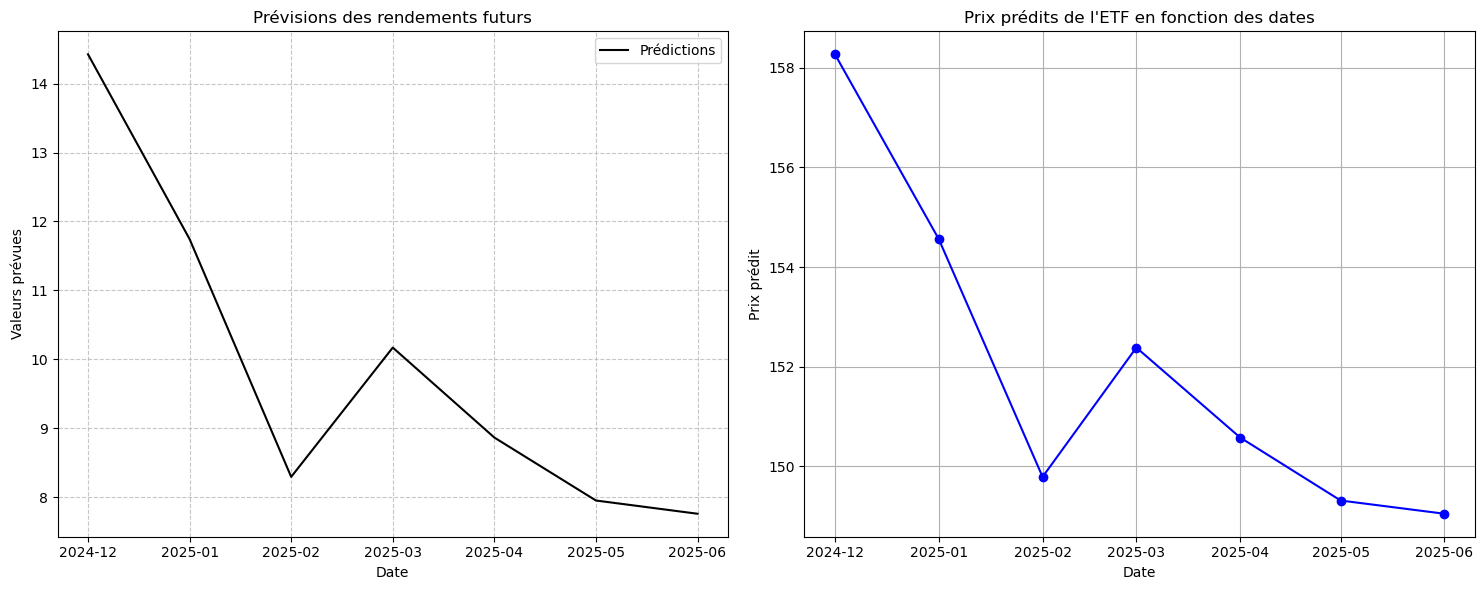

In [7]:
last_date = pmi_data['Date'].max()
last_date = pd.to_datetime(last_date)
start_date_future = last_date + pd.DateOffset(months=1)
start_date_future = start_date_future.strftime('%Y-%m')
end_date_future = '2025-06'

index_future = pd.date_range(start=start_date_future, end=end_date_future, freq='MS')
forecasts_future = results.get_forecast(steps=len(index_future), exog=merged_data[['RSXFS']].values[-len(index_future):]).predicted_mean
df_forecasts_future = pd.DataFrame(forecasts_future, index=index_future, columns=['Predicted_Returns'])
df_forecasts_future.index = df_forecasts_future.index.strftime('%Y-%m')
df_forecasts_future_returns = df_forecasts_future.copy()

first_predicted_date = df_forecasts_future_returns.index[0]
last_historical_price = pmi_data.loc[pmi_data['Date'] < first_predicted_date, 'XLI'].iloc[-1]
future_prices_sarimax = pd.DataFrame(index=range(len(df_forecasts_future_returns)), columns=df_forecasts_future_returns.columns)

for index, row in df_forecasts_future_returns.iterrows():
    price = last_historical_price
    for date, ret in zip(df_forecasts_future_returns.columns, row):
        price *= (1 + ret / 100)
        future_prices_sarimax.loc[index, date] = price

future_prices_sarimax.rename(columns=lambda x: 'Predicted_prices', inplace=True)
future_prices_sarimax.dropna(inplace=True)
future_prices_sarimax.index = pd.to_datetime(future_prices_sarimax.index)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(df_forecasts_future.index, df_forecasts_future['Predicted_Returns'], linestyle='-', color='black', label='Prédictions')
axs[0].set_title('Prévisions des rendements futurs')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Valeurs prévues')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].legend()

axs[1].plot(future_prices_sarimax.index, future_prices_sarimax['Predicted_prices'], color='blue', marker='o', linestyle='-')
axs[1].set_title('Prix prédits de l\'ETF en fonction des dates')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Prix prédit')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [8]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data['Volatilité'] = merged_data['Returns'].rolling(window=12).std() * (12 ** 0.5)
merged_data = merged_data.dropna()
merged_data.reset_index(drop=True, inplace=True)
merged_data

,Date,RSXFS,Returns,Volatilité
0,1999-12-01,239589.0,0.747253,12.204882
1,2000-01-01,237541.0,0.942475,12.213592
2,2000-02-01,241541.0,-7.479673,15.125466
3,2000-03-01,244533.0,3.708869,15.338347
4,2000-04-01,239552.0,7.461384,14.051677
...,...,...,...,...
295,2024-07-01,605814.0,1.772628,11.829223
296,2024-08-01,603719.0,1.679240,11.595110
297,2024-09-01,608701.0,3.970086,10.584762
298,2024-10-01,612570.0,4.360078,8.640593


In [9]:
X = merged_data['Returns'].values
exog_data = merged_data['RSXFS'].values

memory = Memory(location='cache_folder', verbose=0)

p = q = range(0, 5)
pdq = list(itertools.product(p, q))

@memory.cache
def fit_garch(train, exog, param):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = arch_model(train, x=exog, vol='GARCH', p=param[0], q=param[1], dist='skewt')
            results = model.fit(disp='off')
        return results.aic
    except Exception as e:
        return None

list_param = []
list_results_aic = []

best_aic = float('inf')

time_series_splits = TimeSeriesSplit(n_splits=5)

try:
    for index, (train_index, test_index) in enumerate(time_series_splits.split(X)):
        train, test = X[train_index], X[test_index]
        exog_train, exog_test = exog_data[train_index], exog_data[test_index]
        for param in pdq:
            aic = fit_garch(train, exog_train, param)
            if aic is not None:
                if aic < best_aic:
                    best_aic = aic
                    best_param = param
                list_param.append(param)
                list_results_aic.append(aic)

except KeyboardInterrupt:
    print("\nInterruption de l'exécution.")

best_index = list_results_aic.index(min(list_results_aic))
best_param_garch = list_param[best_index]
best_aic_garch = list_results_aic[best_index]

print(f"Meilleurs paramètres (p,q) : {best_param_garch}")
print(f"Meilleur AIC obtenu : {best_aic_garch}")

c:\Users\Asus-Pc\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Meilleurs paramètres (p,q) : (2, 2)
Meilleur AIC obtenu : 299.76087530601546


c:\Users\Asus-Pc\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


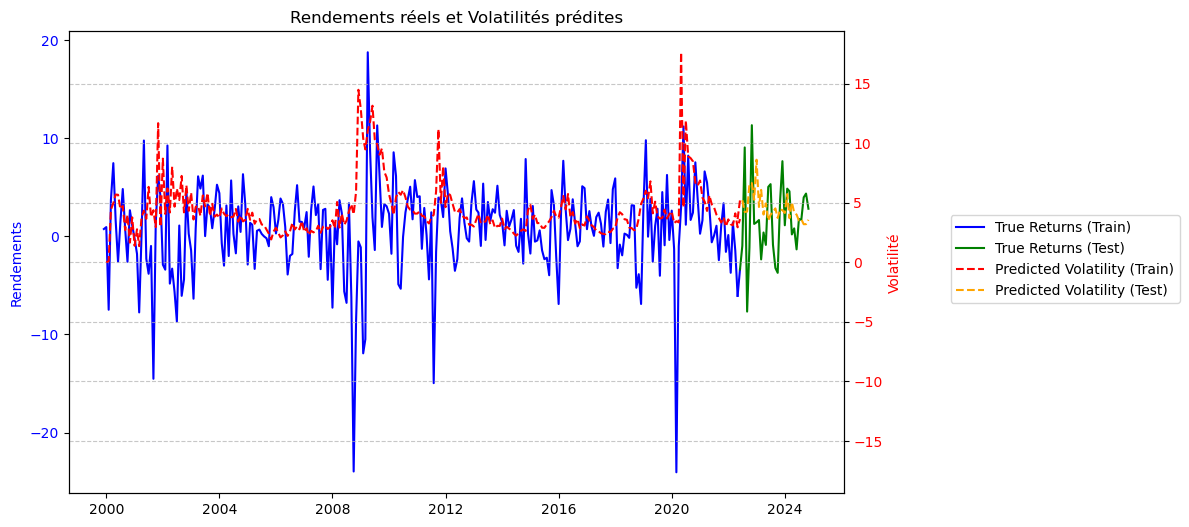

In [10]:
splits_to_test = np.arange(0.1, 1, 0.1)

def train_test_garch(X, exog_data, p, q, split):
    split_index = int(len(X) * split)

    train, test = X[:split_index], X[split_index:]
    exog_train, exog_test = exog_data[:split_index], exog_data[split_index:]

    model = arch_model(train, x=exog_train, vol='GARCH', p=p, q=q, dist='skewt')
    results = model.fit(disp='off')

    forecasts = results.forecast(horizon=len(test))
    forecasted_volatility = np.sqrt(forecasts.variance.values[-1, :])

    prediction_error = np.abs(forecasted_volatility - np.sqrt(np.array(merged_data['Volatilité'][-len(test):])))
    mean_error = np.mean(prediction_error)

    return mean_error

best_p, best_q = best_param_garch

best_split = None
best_error = float('inf')

for split in splits_to_test:
    error = train_test_garch(X, exog_data, best_p, best_q, split)
    if error < best_error:
        best_error = error
        best_split = split


best_p, best_q = best_param_garch

best_split_index = int(len(X) * best_split)

train_data, test_data = X[:best_split_index], X[best_split_index:]
exog_train_data, exog_test_data = exog_data[:best_split_index], exog_data[best_split_index:]

model = arch_model(train_data, x=exog_train_data, vol='GARCH', p=best_p, q=best_q)
results = model.fit(disp='off')

forecasted_volatility = []

for i in range(len(test_data)):
    model = arch_model(np.concatenate([train_data, test_data[:i]]),
                       x=np.concatenate([exog_train_data, exog_test_data[:i]]),
                       vol='GARCH', p=best_p, q=best_q)
    results = model.fit(disp='off')

    forecast = results.forecast(horizon=1)
    forecasted_volatility.append(np.sqrt(forecast.variance.values[-1, 0]))

true_volatility = merged_data['Volatilité'].values[-len(test_data):]


warnings.filterwarnings("ignore", category=ConvergenceWarning)

returns_train = merged_data['Returns'].iloc[:best_split_index]
returns_test = merged_data['Returns'].iloc[best_split_index:]

predicted_volatility_train = []
predicted_volatility_test = []

for i in range(len(merged_data) - 1):
    train_data = merged_data.iloc[:i+1]
    exog_train = train_data['RSXFS'].values
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    model = arch_model(train_data['Returns'], x=exog_train, vol='GARCH', p=best_p, q=best_q)
    results = model.fit(disp='off')

    forecast = results.forecast(horizon=1)
    predicted_volatility = np.sqrt(forecast.variance.values[-1, :])

    if i < best_split_index:
        predicted_volatility_train.append(predicted_volatility)
    else:
        predicted_volatility_test.append(predicted_volatility)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(merged_data['Date'].iloc[:best_split_index], returns_train, label='True Returns (Train)', color='blue')
ax1.plot(merged_data['Date'].iloc[best_split_index-1:best_split_index+1], [returns_train.iloc[-1], returns_test.iloc[0]], color='blue')
ax1.plot(merged_data['Date'].iloc[best_split_index:], returns_test, label='True Returns (Test)', color='green')
ax1.set_ylabel('Rendements', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(merged_data['Date'].iloc[1:best_split_index+1], predicted_volatility_train, label='Predicted Volatility (Train)', color='red', linestyle='--')
ax2.plot(merged_data['Date'].iloc[best_split_index-1:best_split_index+1], [predicted_volatility_train[-1], predicted_volatility_test[0]], color='red', linestyle='--')
ax2.plot(merged_data['Date'].iloc[best_split_index+1:], predicted_volatility_test, label='Predicted Volatility (Test)', color='orange', linestyle='--')
ax2.set_ylabel('Volatilité', color='red')
ax2.tick_params(axis='y', labelcolor='red')

volatility_min = min(np.min(predicted_volatility_train), np.min(predicted_volatility_test))
volatility_max = max(np.max(predicted_volatility_train), np.max(predicted_volatility_test))
volatility_range = max(abs(volatility_min), abs(volatility_max)) * 1.1
ax2.set_ylim(-volatility_range, volatility_range)

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Rendements réels et Volatilités prédites')
plt.xlabel('Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.show()

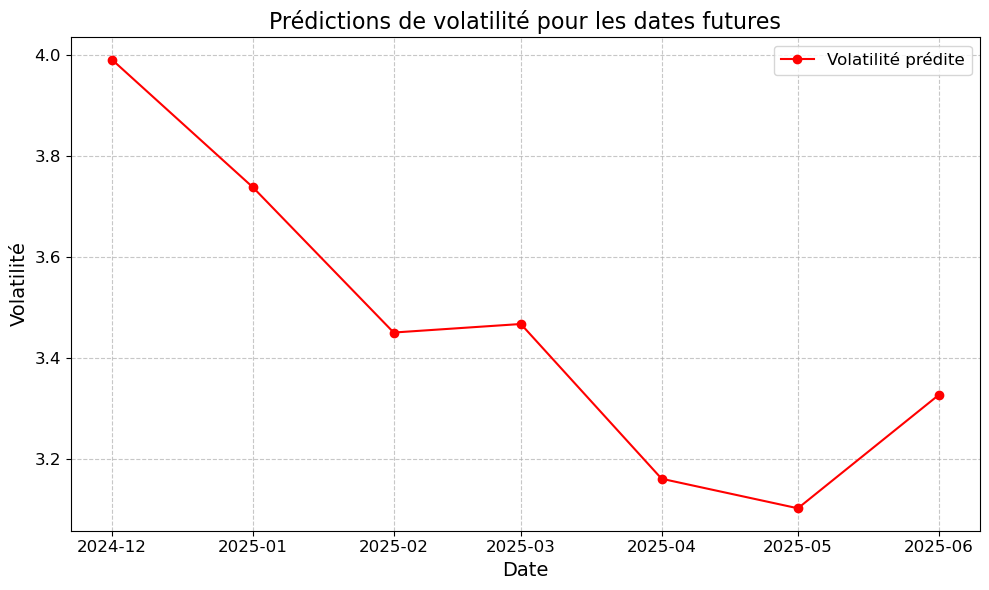

In [13]:
index_future = pd.date_range(start=start_date_future, end=end_date_future, freq='MS')

def rolling_forecast_garch(X, exog_data, p, q, index_future):
    forecasts_future = []
    for i in range(len(index_future)):
        train_data = X[:len(X) - len(index_future) + i]
        exog_train = exog_data[:len(X) - len(index_future) + i]

        model = arch_model(train_data, x=exog_train, vol='GARCH', p=p, q=q, dist='skewt')
        results = model.fit(disp='off')

        forecast = results.forecast(horizon=1).variance.iloc[-1, -1]
        forecasts_future.append(np.sqrt(forecast))
    return forecasts_future

index_future = pd.date_range(start=start_date_future, end=end_date_future, freq='MS')
forecasts_future = rolling_forecast_garch(X, exog_data, best_p, best_q, index_future)
df_forecasts_future = pd.DataFrame(forecasts_future, index=index_future, columns=['Predicted_Volatility'])
df_forecasts_future_volatility = df_forecasts_future.copy()
df_forecasts_future_volatility.index = df_forecasts_future_volatility.index.strftime('%Y-%m')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

axes.plot(df_forecasts_future.index, df_forecasts_future['Predicted_Volatility'], marker='o', color='red', label='Volatilité prédite')
axes.set_title('Prédictions de volatilité pour les dates futures', fontsize=16)
axes.set_xlabel('Date', fontsize=14)
axes.set_ylabel('Volatilité', fontsize=14)
axes.legend(fontsize=12)
axes.tick_params(axis='both', which='major', labelsize=12)
axes.tick_params(axis='both', which='minor', labelsize=12)
axes.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

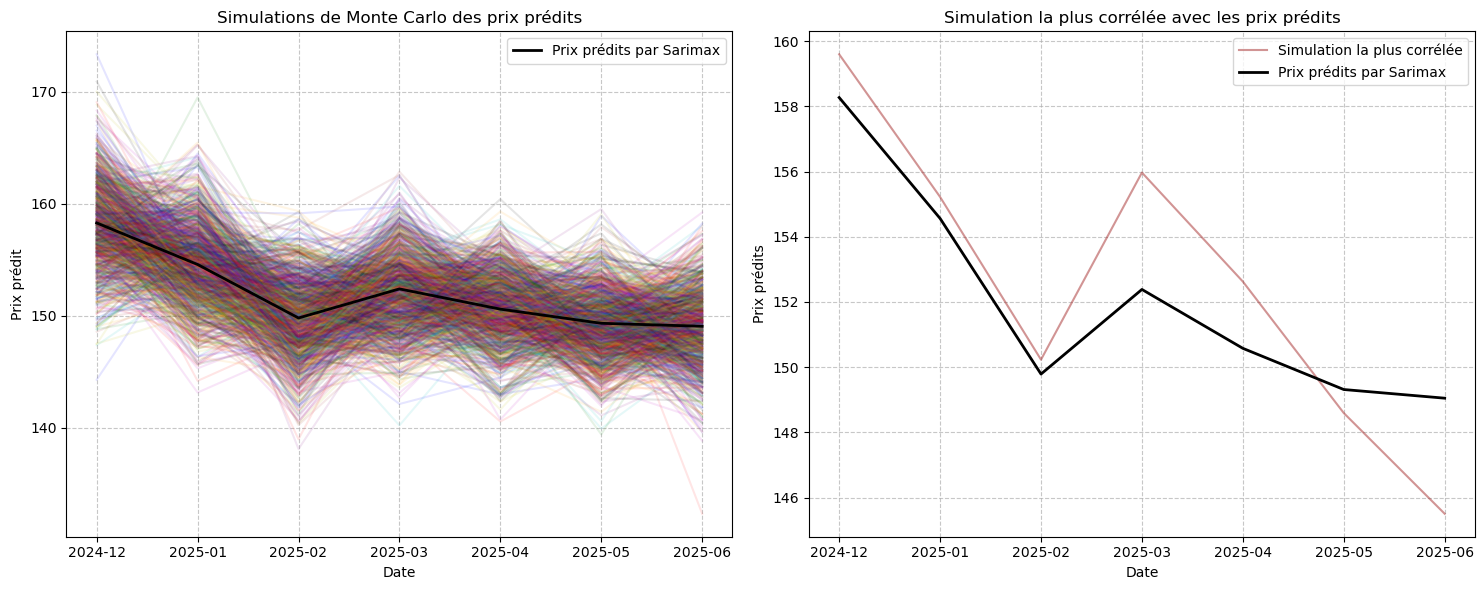

In [15]:
future_prices_sarimax.index = pd.to_datetime(future_prices_sarimax.index)
future_prices_sarimax.index = future_prices_sarimax.index.strftime('%Y-%m')
predicted_data = pd.merge(df_forecasts_future_volatility, future_prices_sarimax, left_index=True, right_index=True)

num_simulations = 1000

def monte_carlo_simulations(prices, std, num_simulations):
    return np.random.normal(prices, std, num_simulations)

simulated_prices = pd.DataFrame()

for index, row in predicted_data.iterrows():
    mean_price = row['Predicted_prices']
    std_dev = row['Predicted_Volatility']

    simulated_values = monte_carlo_simulations(mean_price, std_dev, num_simulations)
    temp_df = pd.DataFrame(simulated_values, columns=[index])
    simulated_prices = pd.concat([simulated_prices, temp_df], axis=1)

correlations = simulated_prices.corrwith(predicted_data['Predicted_prices'])
most_correlated_index = np.argmax(correlations)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].set_title('Simulations de Monte Carlo des prix prédits')
for i in range(num_simulations):
    axs[0].plot(simulated_prices.columns, simulated_prices.iloc[i], color=colors[i % len(colors)], alpha=0.1)
axs[0].plot(predicted_data.index, predicted_data['Predicted_prices'], color='black', linewidth=2, label='Prix prédits par Sarimax')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Prix prédit')
axs[0].legend()
axs[0].tick_params(rotation=0)
axs[0].grid(True, linestyle='--', alpha=0.7)

axs[1].set_title('Simulation la plus corrélée avec les prix prédits')
axs[1].plot(simulated_prices.columns, simulated_prices.iloc[most_correlated_index], color=colors[most_correlated_index % len(colors)], alpha=0.5, label='Simulation la plus corrélée')
axs[1].plot(predicted_data.index, predicted_data['Predicted_prices'], color='black', linewidth=2, label='Prix prédits par Sarimax')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Prix prédits')
axs[1].legend()
axs[1].tick_params(rotation=0)
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()